In [186]:
import os
os.chdir('/Users/mikelgallo/repos2/DeepL_test')

In [187]:
# imports
#Data Manipulation
import pandas as pd
import numpy as pd

#Model fitting, performance, balancing
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors 
from sklearn.model_selection import train_test_split
from Functions.helper_functions import *
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVR , SVC

In [188]:
#Defining repository path
#data_path = '/Users/mikelgallo/repos2/DeepL_test/Session 1_ Nearest Neighbors/'
data_path = './Session 1_ Nearest Neighbors/data/'

In [189]:
# Read data Train 
df = pd.read_csv(data_path+'mimic_train.csv')

# Read data Test
df_test = pd.read_csv(data_path+'mimic_test_death.csv')

In [190]:
#There is a large difference 
print(df.shape)
print(df_test.shape)

(20885, 44)
(5221, 39)


In [191]:
#Which is our dependent variable?
df['HOSPITAL_EXPIRE_FLAG'].unique()

array([0, 1])

In [192]:
# Select columns in test and add the Outcome variable to subset our train data set
df_test_cols = df_test.columns.tolist()
df_test_cols.append('HOSPITAL_EXPIRE_FLAG')

In [193]:
len(df_test_cols)

40

In [194]:
#Creating new subset
df_train= df[df_test_cols]

In [195]:
# The only column difference is our outcome variable
print(df_train.shape)
print(df_test.shape)

(20885, 40)
(5221, 39)


## Preprocessing

In [196]:
#STEP 1 - Split columns into Continuous, Discrete, Categorical
def numeric_cols(dataset):
    numeric = dataset.select_dtypes(include = np.number).columns.tolist()
    return numeric
#STEP 2 - Rough Estimate of Continuous and Discrete columns
def cont_or_disc(dataset,num):
    dict = {}
    numeric = numeric_cols(dataset)
    df_numeric = dataset[numeric]
    for i in df_numeric:
        count = df_numeric[i].count()
        unique_vals = len(df_numeric[i].unique())
        type = 'Discrete' if unique_vals < num else 'Continuous'
        dtype = df_numeric[i].dtype
        dict[i] = [count, unique_vals, type, dtype]
    result = pd.DataFrame.from_dict(dict,orient='index',columns=['count', 'unique_vals', 'type', 'dtype'])
    return result
#STEP 3 - Return column names for discrete and continuous    
def numeric_col_split(df,num):
    new_df = cont_or_disc(df,num)
    cont_cols = []
    disc_cols = []
    for index,row in new_df.iterrows():
        if row['type'] == 'Discrete':
            disc_cols.append(index)
        elif row['type'] == 'Continuous':
            cont_cols.append(index)
    return disc_cols, cont_cols        

In [197]:
#Return all numeric variables 
cont_or_disc(df_train,10)

,count,unique_vals,type,dtype
subject_id,20885,16317,Continuous,int64
hadm_id,20885,19749,Continuous,int64
icustay_id,20885,20885,Continuous,int64
HeartRate_Min,18698,132,Continuous,float64
HeartRate_Max,18698,165,Continuous,float64
HeartRate_Mean,18698,14092,Continuous,float64
SysBP_Min,18677,155,Continuous,float64
SysBP_Max,18677,191,Continuous,float64
SysBP_Mean,18677,13780,Continuous,float64
DiasBP_Min,18676,96,Continuous,float64


In [198]:
disc_cols, cont_cols  = numeric_col_split(df_train,10)

In [199]:
# Conitnuous columns
print('Continuous')
print(cont_cols)
# Discrete columns
print('Dsicrete')
print(disc_cols)

Continuous
['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'Diff']
Dsicrete
['HOSPITAL_EXPIRE_FLAG']


In [200]:
## Check class balance of our outcome variable
## Train Data
df_train['HOSPITAL_EXPIRE_FLAG'].value_counts()

HOSPITAL_EXPIRE_FLAG
0    18540
1     2345
Name: count, dtype: int64

## continuous variables

In [201]:
df_train[cont_cols].describe()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff
count,20885.000000,20885.000000,20885.000000,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,18676.000000,...,18388.000000,18388.000000,18388.000000,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000,20885.000000
mean,58950.496098,150082.402298,250202.495523,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,44.327854,...,36.051208,37.428781,36.751717,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428,-51617.069830
std,25299.439535,28898.479845,28909.806302,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,11.909852,...,0.732124,0.799897,0.603476,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145,10686.395846
min,23.000000,100001.000000,200001.000000,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,4.000000,...,15.000000,30.800000,30.666667,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000,-72740.274440
25%,41132.000000,125157.000000,225153.000000,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,37.000000,...,35.666667,36.944444,36.388889,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000,-60864.454110
50%,60441.000000,150152.000000,250452.000000,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,44.000000,...,36.111111,37.333333,36.731481,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667,-51561.703460
75%,80286.000000,175017.000000,275303.000000,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,51.000000,...,36.500000,37.888889,37.092593,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571,-42327.560030
max,99999.000000,199999.000000,299998.000000,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,105.000000,...,40.100000,42.000000,40.238333,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000,-32157.494580


## Missing Values

In [202]:
## Getting columns with missing values
missing_cols = []
for i in df_train[cont_cols]:
    if df_train[i].isna().mean() > 0:
        missing_cols.append(i)
print(missing_cols)

['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean']


In [203]:
## Simple imputation of means
#missing_cols = df.columns
#for col  in missing_cols:
    #mean = df_train[col].mean()
    #df_train[col].fillna(mean,inplace=True)
    #df_test[col].fillna(mean,inplace=True)

In [204]:
df_train.isna().mean()

subject_id              0.000000
hadm_id                 0.000000
icustay_id              0.000000
HeartRate_Min           0.104716
HeartRate_Max           0.104716
HeartRate_Mean          0.104716
SysBP_Min               0.105722
SysBP_Max               0.105722
SysBP_Mean              0.105722
DiasBP_Min              0.105770
DiasBP_Max              0.105770
DiasBP_Mean             0.105770
MeanBP_Min              0.104668
MeanBP_Max              0.104668
MeanBP_Mean             0.104668
RespRate_Min            0.104812
RespRate_Max            0.104812
RespRate_Mean           0.104812
TempC_Min               0.119559
TempC_Max               0.119559
TempC_Mean              0.119559
SpO2_Min                0.105482
SpO2_Max                0.105482
SpO2_Mean               0.105482
Glucose_Min             0.012114
Glucose_Max             0.012114
Glucose_Mean            0.012114
GENDER                  0.000000
DOB                     0.000000
ADMITTIME               0.000000
Diff      

## KNN Imputation + SCALING

In [205]:
## Removing ID columns from continuous variables list
ID_list = ['subject_id', 'hadm_id', 'icustay_id']
new_cont_list = [col for col in cont_cols if col not in ID_list]
print(new_cont_list)

['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'Diff']


In [206]:
#Step 1 - Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_train[new_cont_list])

df_train[new_cont_list] = scaler.transform(df_train[new_cont_list])
df_test[new_cont_list] = scaler.transform(df_test[new_cont_list])


/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_29624/4013778984.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[new_cont_list] = scaler.transform(df_train[new_cont_list])


In [207]:
# KNN imputation
from sklearn.impute import KNNImputer
# Create a KNNImputer object with k=3 
imputer = KNNImputer(n_neighbors=3) 

# Perform KNN imputation only on the specified columns for the training data
df_train[new_cont_list] = imputer.fit_transform(df_train[new_cont_list])

# Perform KNN imputation on the same columns for the test data (use the same imputer)
df_test[new_cont_list] = imputer.transform(df_test[new_cont_list])

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_29624/2808671186.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[new_cont_list] = imputer.fit_transform(df_train[new_cont_list])


In [208]:
for i in df_train:
    if df_train[i].isna().mean() > 0:
        print(i,' : ', df_train[i].isna().mean())

MARITAL_STATUS  :  0.03457026574096241


## Categoricals

In [209]:
def categoricals(dataset):
    dict = {}
    for i in dataset:
        count = dataset[i].count()
        unique_vals = len(dataset[i].unique())
        dtype = dataset[i].dtype
        dict[i] = [count, unique_vals, dtype]
    result = pd.DataFrame.from_dict(dict,orient='index',columns=['count', 'unique_vals','dtype'])
    return result

In [210]:
# For now we are going to get rid of categoricals - except for Maritimal 
numerics = numeric_cols(df_train)
non_numeric = [col for col in df_train.columns if col not in numerics]

In [211]:
df_train[non_numeric].head()

,GENDER,DOB,ADMITTIME,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,F,2108-07-16 00:00:00,2178-02-06 10:35:00,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU
1,F,2087-01-16 00:00:00,2129-02-12 22:34:00,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU
2,F,2057-09-17 00:00:00,2125-11-17 23:04:00,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU
3,F,2056-02-27 00:00:00,2131-01-26 08:00:00,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU
4,F,2066-12-19 00:00:00,2146-05-04 02:02:00,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU


In [212]:
categoricals(df_train[non_numeric])

,count,unique_vals,dtype
GENDER,20885,2,object
DOB,20885,14007,object
ADMITTIME,20885,19714,object
ADMISSION_TYPE,20885,3,object
INSURANCE,20885,5,object
RELIGION,20885,17,object
MARITAL_STATUS,20163,8,object
ETHNICITY,20885,41,object
DIAGNOSIS,20885,6193,object
ICD9_diagnosis,20885,1853,object


In [213]:
for i in df_train[non_numeric]:
    if len(df_train[i].unique()) <= 5:
        print(i)
        print(df_train[i].unique())

GENDER
['F' 'M']
ADMISSION_TYPE
['EMERGENCY' 'ELECTIVE' 'URGENT']
INSURANCE
['Medicare' 'Private' 'Medicaid' 'Self Pay' 'Government']
FIRST_CAREUNIT
['MICU' 'SICU' 'TSICU' 'CSRU' 'CCU']


In [214]:
#Label Encoding
#Gender = Boolean (DONE)
#ADMISSION_TYPE = Label Encoding Ordinal (DONE)
#First_Careunit = Dummies (DONE)

## Label Encoding

In [215]:
gender_enc = [1 if i == 'M' else 0 for i in df_train['GENDER']]
gender_enc_t = [1 if i == 'M' else 0 for i in df_test['GENDER']]

df_train['GENDER_ENC'] = gender_enc
df_test['GENDER_ENC'] = gender_enc_t

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_29624/1981787072.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['GENDER_ENC'] = gender_enc


In [216]:
admiss_type_enc = [3 if i == 'EMERGENCY' else 2 if i == 'URGENT' else 1 for i in df_train['ADMISSION_TYPE']]
admiss_type_enc_t = [3 if i == 'EMERGENCY' else 2 if i == 'URGENT' else 1 for i in df_test['ADMISSION_TYPE']]

df_train['ADMISSION_TYPE_ENC'] = admiss_type_enc
df_test['ADMISSION_TYPE_ENC'] = admiss_type_enc_t

scaler2 = StandardScaler()
scaler2.fit(df_train[['ADMISSION_TYPE_ENC']])

df_train['ADMISSION_TYPE_ENC'] = scaler2.transform(df_train[['ADMISSION_TYPE_ENC']])
df_test['ADMISSION_TYPE_ENC'] = scaler2.transform(df_test[['ADMISSION_TYPE_ENC']])

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_29624/797093926.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ADMISSION_TYPE_ENC'] = admiss_type_enc
/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_29624/797093926.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ADMISSION_TYPE_ENC'] = scaler2.transform(df_train[['ADMISSION_TYPE_ENC']])


In [217]:
#Creating Dummies for Diagnosis
#tables = pd.DataFrame(df_train.groupby('DIAGNOSIS')['HOSPITAL_EXPIRE_FLAG'].mean())
#tables = tables.reset_index()
#tables = tables.sort_values(by='HOSPITAL_EXPIRE_FLAG',ascending = False)
#deadlly_diagnosis = tables['DIAGNOSIS'][tables['HOSPITAL_EXPIRE_FLAG'] > 0]

#encode = [1 if i in deadlly_diagnosis else 0 for i in df_train['DIAGNOSIS']]
#encode_t = [1 if i in deadlly_diagnosis else 0 for i in df_test['DIAGNOSIS']]

#df_train['DIAGNOSIS_ENC'] = encode
#df_test['DIAGNOSIS_ENC'] = encode_t

## Creating Dummies

In [218]:
def encode(df, columns_hot):
    encoded_df = pd.get_dummies(df, columns=columns_hot, dtype=float)
    return encoded_df
#E.g. df = encode(df, ['orientation', 'neighborhood'])

In [219]:
df_train = encode(df_train,['FIRST_CAREUNIT'])
df_test = encode(df_test,['FIRST_CAREUNIT'])

In [220]:
# NEW Categorical enconded
enconded_list = ['GENDER_ENC', 'ADMISSION_TYPE_ENC',
       'FIRST_CAREUNIT_CCU', 'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_MICU',
       'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU','DIAGNOSIS_ENC']

## Removing all Categoricals and leaving just numeric

In [221]:
# For now we are going to get rid of categoricals - except for Maritimal 
numerics = numeric_cols(df_train)
non_numeric = [col for col in df_train.columns if col not in numerics]

In [222]:
#Remove all non-numeric from datasets
df_train = df_train.drop(non_numeric,axis = 1)
df_test = df_test.drop(non_numeric,axis = 1)
#df = df.drop(['column'],axis=1)

In [223]:
df_train.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'Diff',
       'HOSPITAL_EXPIRE_FLAG', 'GENDER_ENC', 'ADMISSION_TYPE_ENC',
       'FIRST_CAREUNIT_CCU', 'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_MICU',
       'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU'],
      dtype='object')

Text(0.5, 1.0, 'Correlation Matrix (Quantitative Variables)')

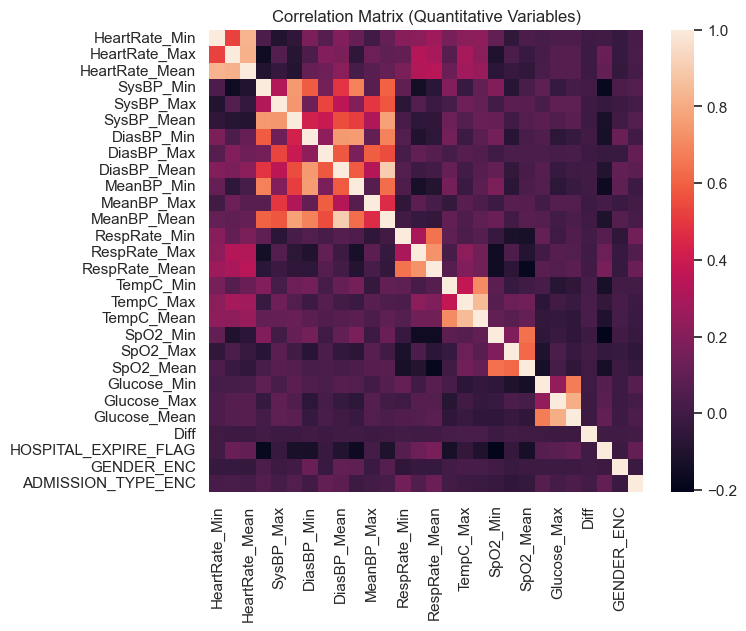

In [251]:
# Correlations among the variables 
df_for_heatmap = df_train.drop(['subject_id', 'hadm_id', 'icustay_id','FIRST_CAREUNIT_CCU', 'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_MICU',
       'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU'], axis=1)
df_for_heatmap_corr = df_for_heatmap.corr()

# Plot correlations
fig, ax = plt.subplots(figsize=(7,6))
ax = sns.heatmap(df_for_heatmap_corr, annot = False, )
plt.title('Correlation Matrix (Quantitative Variables)')

In [256]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
#Measuring Multicolinearity

#find design matrix for regression model using 'rating' as response variable 
y, X = dmatrices('HOSPITAL_EXPIRE_FLAG ~ HeartRate_Min+HeartRate_Max+HeartRate_Mean+SysBP_Min+SysBP_Max+SysBP_Mean+DiasBP_Min+DiasBP_Max+DiasBP_Mean+MeanBP_Min+MeanBP_Max+MeanBP_Mean+RespRate_Min+RespRate_Max+RespRate_Mean+TempC_Min+TempC_Max+TempC_Mean+SpO2_Min+SpO2_Max+SpO2_Mean+Glucose_Min+Glucose_Max+Glucose_Mean+Diff', data=df_train, return_type='dataframe')

#create DataFrame to hold VIF values
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 

#calculate VIF for each predictor variable 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#view VIF for each predictor variable 
print(vif_df)

          variable        VIF
0        Intercept   1.021899
1    HeartRate_Min   4.391229
2    HeartRate_Max   4.015337
3   HeartRate_Mean   9.243623
4        SysBP_Min   4.407970
5        SysBP_Max   4.067596
6       SysBP_Mean  10.291895
7       DiasBP_Min   4.096916
8       DiasBP_Max   2.755816
9      DiasBP_Mean  13.283062
10      MeanBP_Min   3.150432
11      MeanBP_Max   2.245266
12     MeanBP_Mean  20.076315
13    RespRate_Min   2.043970
14    RespRate_Max   2.541427
15   RespRate_Mean   3.978742
16       TempC_Min   3.430899
17       TempC_Max   6.202803
18      TempC_Mean  10.455463
19        SpO2_Min   2.106146
20        SpO2_Max   1.863322
21       SpO2_Mean   3.163419
22     Glucose_Min   3.838096
23     Glucose_Max   5.928249
24    Glucose_Mean  10.343972
25            Diff   1.003238


In [259]:
Columns_vif = ['HeartRate_Mean','SysBP_Mean','DiasBP_Mean','MeanBP_Mean','TempC_Mean','Glucose_Mean']
Columns_vif_target = ['HeartRate_Mean','SysBP_Mean','DiasBP_Mean','MeanBP_Mean','TempC_Mean','Glucose_Mean','HOSPITAL_EXPIRE_FLAG']

Text(0.5, 1.0, 'Correlation Matrix (Quantitative Variables)')

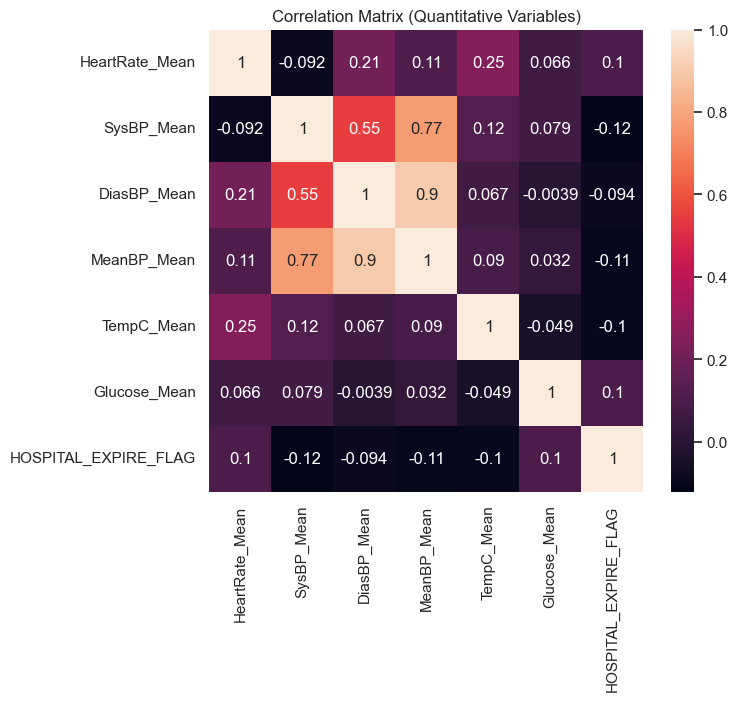

In [263]:
df_for_heatmap = df_train[Columns_vif_target]
df_for_heatmap_corr = df_for_heatmap.corr()

# Plot correlations
fig, ax = plt.subplots(figsize=(7,6))
ax = sns.heatmap(df_for_heatmap_corr, annot = True, )
plt.title('Correlation Matrix (Quantitative Variables)')

In [264]:
new_columns = [i for i in df_train.columns if i not in Columns_vif]

Text(0.5, 1.0, 'Correlation Matrix (Quantitative Variables)')

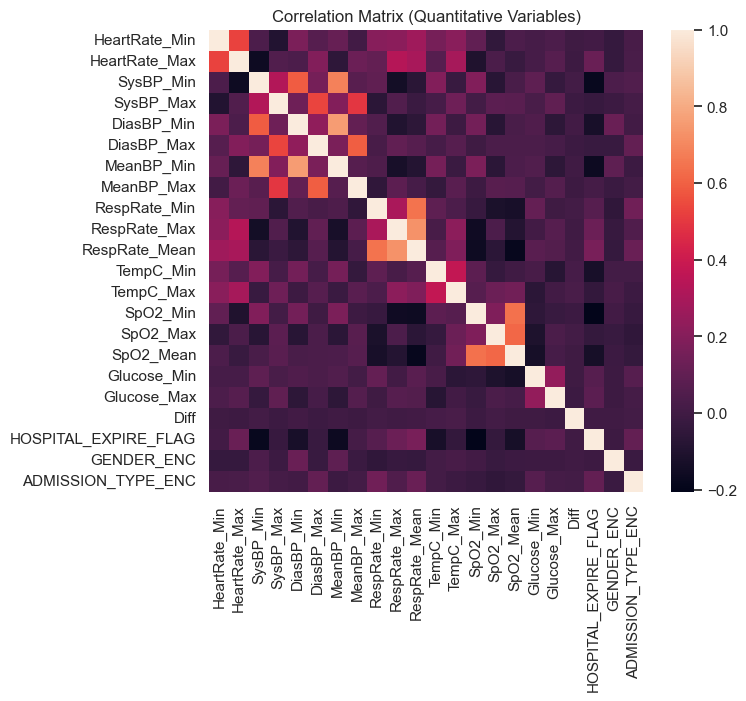

In [268]:

df_for_heatmap = df_train[new_columns].drop(['subject_id', 'hadm_id', 'icustay_id','FIRST_CAREUNIT_CCU', 'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_MICU',
       'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU'], axis=1)

df_for_heatmap_corr = df_for_heatmap.corr()

# Plot correlations
fig, ax = plt.subplots(figsize=(7,6))
ax = sns.heatmap(df_for_heatmap_corr, annot = False, )
plt.title('Correlation Matrix (Quantitative Variables)')

In [276]:
corr_target = pd.DataFrame(df_for_heatmap_corr['HOSPITAL_EXPIRE_FLAG'].round(2)).reset_index()

In [305]:
columnsa = []
for var,value in zip(corr_target['index'],corr_target['HOSPITAL_EXPIRE_FLAG']):
    if value < 0.05 and value >= 0:
        pass
    elif value < 0 and value >= -0.05:
        pass
    else:
        print(var,value)
        columnsa.append(var)

HeartRate_Max 0.12
SysBP_Min -0.18
DiasBP_Min -0.13
MeanBP_Min -0.16
RespRate_Min 0.07
RespRate_Max 0.13
RespRate_Mean 0.16
TempC_Min -0.13
SpO2_Min -0.2
SpO2_Mean -0.13
Glucose_Min 0.07
Glucose_Max 0.08
HOSPITAL_EXPIRE_FLAG 1.0
ADMISSION_TYPE_ENC 0.1


In [306]:
#Train
columnsa.extend(['subject_id', 'hadm_id', 'icustay_id'])
#Test
columnsa_t = columnsa.copy()
columnsa_t.remove('HOSPITAL_EXPIRE_FLAG')
columnsa_t

['HeartRate_Max',
 'SysBP_Min',
 'DiasBP_Min',
 'MeanBP_Min',
 'RespRate_Min',
 'RespRate_Max',
 'RespRate_Mean',
 'TempC_Min',
 'SpO2_Min',
 'SpO2_Mean',
 'Glucose_Min',
 'Glucose_Max',
 'ADMISSION_TYPE_ENC',
 'subject_id',
 'hadm_id',
 'icustay_id']

In [308]:
## Try new dataset
df_simple = df_train[columnsa]
df_timple = df_test[columnsa_t]

## Spliting Data

In [309]:
df_simple.columns

Index(['HeartRate_Max', 'SysBP_Min', 'DiasBP_Min', 'MeanBP_Min',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'SpO2_Min', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'HOSPITAL_EXPIRE_FLAG', 'ADMISSION_TYPE_ENC', 'subject_id', 'hadm_id',
       'icustay_id'],
      dtype='object')

In [311]:
from sklearn.model_selection import train_test_split
# In case we use directly a Train and Test datatset
#Xtrain = df_train.drop(['HOSPITAL_EXPIRE_FLAG','subject_id','hadm_id','icustay_id'],axis = 1)
#ytrain = df_train['HOSPITAL_EXPIRE_FLAG']
#Xtest_id = df_test[['icustay_id']]
#Xtest = df_test.drop(['subject_id','hadm_id','icustay_id'],axis = 1) #probably it doesnt require to remove any column

#Experiment
Xtrain = df_simple.drop(['HOSPITAL_EXPIRE_FLAG','subject_id','hadm_id','icustay_id'],axis = 1)
ytrain = df_simple['HOSPITAL_EXPIRE_FLAG']
Xtest_id = df_timple[['icustay_id']]
Xtest = df_timple.drop(['subject_id','hadm_id','icustay_id'],axis = 1) #probably it doesnt require to remove any column

In [312]:
print(Xtrain.shape)
print(Xtest.shape)

(20885, 13)
(5221, 13)


In [313]:
table = pd.DataFrame(ytrain.value_counts())
table = table.reset_index()
table['total'] = table['count'].sum()
table['perc'] = table['count'] / table['total']
table

,HOSPITAL_EXPIRE_FLAG,count,total,perc
0,0,18540,20885,0.887718
1,1,2345,20885,0.112282


<Axes: title={'center': 'Count (target)'}>

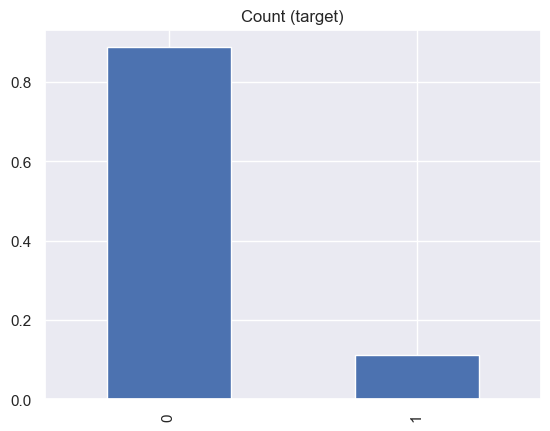

In [314]:
table['perc'].plot(kind='bar', title='Count (target)')

## Adjusting Class Imbalance

In [171]:
# PENDING
#sampling_strategy = 0.5
#ros = RandomOverSampler(sampling_strategy=sampling_strategy)
#X_res, y_res = ros.fit_resample(Xtrain, ytrain)

In [315]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy=0.25)
X_res, y_res = smt.fit_resample(Xtrain, ytrain)

In [316]:
table = pd.DataFrame(y_res.value_counts())
table = table.reset_index()
table['total'] = table['count'].sum()
table['perc'] = table['count'] / table['total']
table

,HOSPITAL_EXPIRE_FLAG,count,total,perc
0,0,18312,22719,0.806021
1,1,4407,22719,0.193979


<Axes: title={'center': 'Count (target)'}>

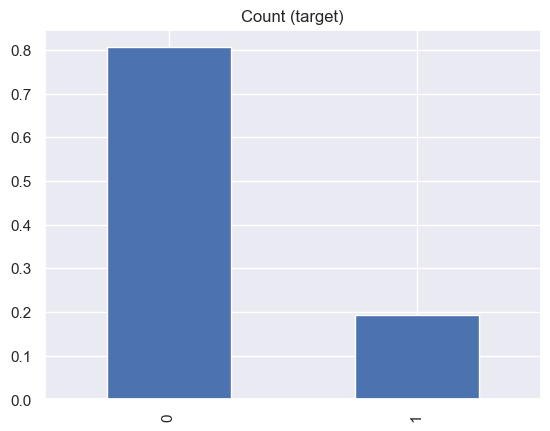

In [317]:
table['perc'].plot(kind='bar', title='Count (target)')

## Fitting simple KNN

In [175]:
# Step 1 - Create an instance of the KNN model
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

KNN_model  = KNeighborsClassifier(n_neighbors=20, algorithm = 'brute',weights='distance')

KNN_model.fit(X_res,y_res)

print(f"Predicted class is ",KNN_model.predict(Xtest))
## Check which other algorithm should we try

Predicted class is  [0 0 0 ... 0 0 0]


In [176]:
y_predict_proba = KNN_model.predict_proba(Xtest)

In [126]:
y_proba = pd.DataFrame(y_predict_proba[:,1])

In [177]:
# Produce .csv for kaggle testing
#test_predictions_submit = pd.DataFrame({"icustay_id": Xtest_id['icustay_id'], "HOSPITAL_EXPIRE_FLAG": y_proba[0]})
#test_predictions_submit.to_csv("test_predictions_submit_knn_adjusted4.csv", index = False)

## KNN Hypertuning GridSearch CV

In [318]:
#np.random.seed(42)
# Step 1 - Create an instance of the KNN model
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

KNN_model  = KNeighborsClassifier(algorithm = 'brute')

# Step 2 - Create our grid_search_values
grid_values = {'n_neighbors': [1, 2, 3, 4 ,5, 10, 12,15,18, 20], 'weights': ['uniform','distance'] }
#grid_values = {'n_neighbors': [20,50, 70, 85, 100, 150, 200], 'weights': ['uniform','distance']}
#grid_values = {'n_neighbors': [100, 120, 200, 250, 300, 350], 'weights': ['uniform','distance']}
#grid_values = {'n_neighbors': [220, 230, 240, 250, 260], 'weights': ['uniform','distance']}
#grid_values = {'n_neighbors': [150, 200, 220, 250, 260], 'weights': ['uniform','distance']}



# Step 3 - Instanciate our gridSearch CV
grid_knn_acc = GridSearchCV(KNN_model, param_grid = grid_values, scoring='f1',cv=20)

#Step 4 - fit model 
grid_knn_acc.fit(X_res,y_res)

GridSearchCV(cv=20, estimator=KNeighborsClassifier(algorithm='brute'),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 12, 15, 18, 20],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

best parameters: {'n_neighbors': 1, 'weights': 'uniform'}
best score:      0.79503 (+/-0.04480)


,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
0,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.734021,0.752556,0.772532,0.735967,0.748441,0.743215,0.762500,...,0.817164,0.861660,0.857700,0.824627,0.838835,0.810409,0.834615,0.795025,0.044800,1
1,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.734021,0.752556,0.772532,0.735967,0.748441,0.743215,0.762500,...,0.817164,0.861660,0.857700,0.824627,0.838835,0.810409,0.834615,0.795025,0.044800,1
3,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.734021,0.752556,0.772532,0.735967,0.748441,0.743215,0.762500,...,0.817164,0.861660,0.857700,0.822430,0.838835,0.810409,0.834615,0.794916,0.044730,3
7,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",0.649573,0.698276,0.694878,0.650759,0.659341,0.693512,0.670940,...,0.810811,0.855984,0.848249,0.809793,0.833992,0.812854,0.820312,0.754270,0.073780,4
9,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.640000,0.684444,0.682028,0.650113,0.648649,0.652778,0.665158,...,0.803960,0.855372,0.847251,0.811881,0.854251,0.805447,0.832998,0.749787,0.079879,5
5,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.662500,0.689362,0.678261,0.662393,0.660907,0.687090,0.683333,...,0.793169,0.850299,0.828516,0.793296,0.821497,0.794063,0.813688,0.749184,0.067930,6
11,10,distance,"{'n_neighbors': 10, 'weights': 'distance'}",0.621027,0.665000,0.640420,0.606061,0.625323,0.652850,0.644501,...,0.762980,0.822989,0.802691,0.772727,0.782022,0.790393,0.814004,0.721654,0.077473,7
2,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.593750,0.634021,0.597333,0.592593,0.617801,0.602667,0.634921,...,0.796421,0.843318,0.828194,0.777273,0.791762,0.796460,0.817582,0.709387,0.095362,8
13,12,distance,"{'n_neighbors': 12, 'weights': 'distance'}",0.604167,0.659794,0.623037,0.596306,0.606383,0.630728,0.638522,...,0.759259,0.815348,0.792627,0.731591,0.754177,0.773756,0.791667,0.705125,0.075243,9
4,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.590810,0.640351,0.592593,0.584270,0.606742,0.620690,0.615721,...,0.760234,0.811475,0.793651,0.735409,0.759036,0.743738,0.774067,0.691848,0.078623,10


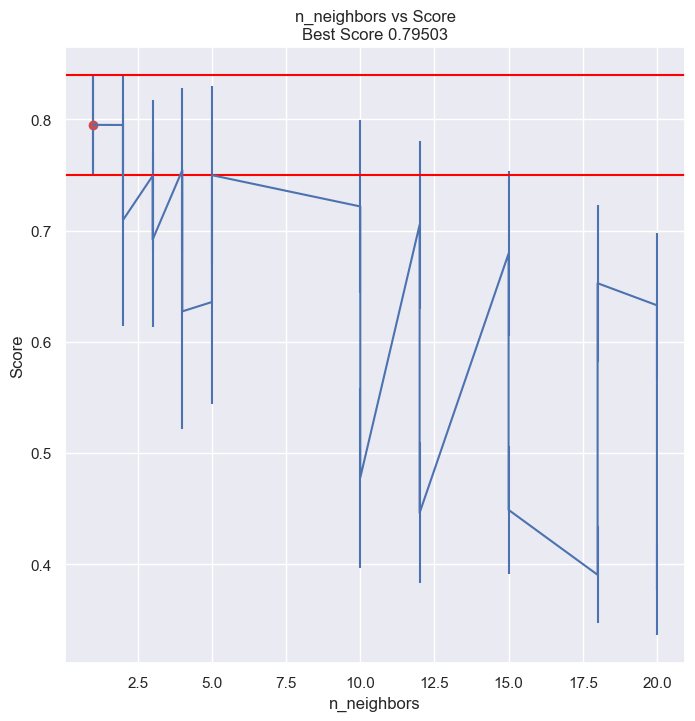

In [319]:
# Report best Number of Neighbors
GridSearch_table_plot(grid_knn_acc, "n_neighbors", negative=False, display_all_params=False)

In [320]:
#Best Result
print('best parameters:', grid_knn_acc.best_params_)
print('best score:', grid_knn_acc.best_score_)

best parameters: {'n_neighbors': 1, 'weights': 'uniform'}
best score: 0.7950254813173225


## Checking Scores

In [321]:
insample_y_pred_acc = grid_knn_acc.predict(X_res)

# Compute different Evaluation metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix

print('Accuracy Score : ' + str(accuracy_score(y_res,insample_y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_res,insample_y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_res,insample_y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_res,insample_y_pred_acc)))

Accuracy Score : 0.9999559839781681
Precision Score : 0.9997731397459165
Recall Score : 1.0
F1 Score : 0.999886557005105


Confusion matrix


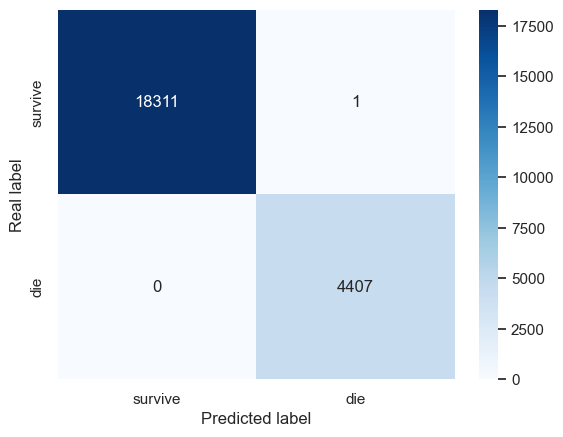

y actual : 
HOSPITAL_EXPIRE_FLAG
0    18312
1     4407
Name: count, dtype: int64
y predicted : 
0    18311
1     4408
Name: count, dtype: int64


In [322]:
#Confusion matrix
print("Confusion matrix")
cm=confusion_matrix(y_res,insample_y_pred_acc)
plot_confusion_matrix(cm, ['survive','die'])
#Distribution of y test
print('y actual : \n' +  str(y_res.value_counts()))
#Distribution of y predicted
print('y predicted : \n' + str(pd.Series(insample_y_pred_acc).value_counts()))

## Generating Predictions for Kaggle

In [54]:
y_predict_grids_proba = grid_knn_acc.predict_proba(Xtest)[:,1]

In [55]:
y_predict_grids_proba

array([0., 0., 0., ..., 0., 0., 0.])

In [56]:
# Produce .csv for kaggle testing
#test_predictions_submit_knn_grid = pd.DataFrame({"icustay_id": Xtest_id['icustay_id'], "HOSPITAL_EXPIRE_FLAG": y_predict_grids_proba[0]})
#test_predictions_submit_knn_grid.to_csv("test_predictions_submit_knn_imputation_f1.csv", index = False)

## Running a SVM

In [529]:
# Create a Support Vector Machine classifier with a linear kernel
classifier = SVC(kernel='rbf', probability=True,C = 10, gamma= 0.5,class_weight='balanced')
#classifier_poly = SVC(kernel='poly', degree=3, probability=True, C=1, class_weight='balanced')

# Train the classifier on the training set
classifier.fit(X_res, y_res)

# Obtain decision values or probabilities on the training set
#y_train_scores = classifier.decision_function(X_train_scaled)  # Use decision_function for linear kernel
# Alternatively, you can use predict_proba for non-linear kernels
y_train_probs = classifier.predict_proba(Xtest)[:, 1]

# Calculate AUC score on the training set
#auc_score_train = roc_auc_score(y_train, y_train_scores)

# Print or use the AUC score as needed
#print("AUC score on the training set:", auc_score_train)

In [530]:
len(y_train_probs)

5221

In [531]:
# Produce .csv for kaggle testing
#test_predictions_submit_SVM = pd.DataFrame({"icustay_id": Xtest_id['icustay_id'], "HOSPITAL_EXPIRE_FLAG": y_train_probs[0]})
#test_predictions_submit_SVM.to_csv("test_predictions_submit_svm_test50.csv", index = False)

## Grid Search SVM

In [323]:
print(X_res.shape)
print(y_res.shape)

(22719, 13)
(22719,)


In [324]:
#Creating a Sample
sample_size = 10000  # Adjust the sample size as needed
# Method 1: Using pandas sample method
X_res_samp = X_res.sample(n=sample_size, random_state=42)
y_res_samp = y_res.sample(n=sample_size, random_state=30)

In [325]:
print(X_res_samp.shape)
print(y_res_samp.shape)

(10000, 13)
(10000,)


In [326]:
from sklearn.model_selection import GridSearchCV

#Svc = SVC(kernel='rbf')
my_balanced_SVM_model = SVC()

grid_values = {'C':[0.1, 1, 10], 'gamma':[0.1,0.25,0.5,0.75], 'kernel':['linear', 'rbf']}
grid_svc_acc = GridSearchCV(my_balanced_SVM_model, param_grid = grid_values,scoring = 'roc_auc', cv=5)

#grid_values = {'C':[0.1, 1, 10], 'gamma':[0.25,0.5,0.75]} # automatic gamma will be gamma=1/num_features
#grid_svc_acc = GridSearchCV(Svc, param_grid = grid_values,scoring = 'roc_auc', cv=5)

In [327]:
grid_svc_acc.fit(X_res_samp, y_res_samp)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.25, 0.5, 0.75],
                         'kernel': ['linear', 'rbf']},
             scoring='roc_auc')

best parameters: {'C': 10, 'gamma': 0.75, 'kernel': 'rbf'}
best score:      0.83366 (+/-0.01441)


,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,10,0.75,rbf,"{'C': 10, 'gamma': 0.75, 'kernel': 'rbf'}",0.821758,0.854743,0.815242,0.832358,0.844207,0.833662,0.014410,1
11,1,0.75,rbf,"{'C': 1, 'gamma': 0.75, 'kernel': 'rbf'}",0.820747,0.856772,0.811279,0.835179,0.841396,0.833074,0.015889,2
5,0.1,0.75,rbf,"{'C': 0.1, 'gamma': 0.75, 'kernel': 'rbf'}",0.815944,0.855449,0.809937,0.832745,0.839326,0.830680,0.016370,3
15,10,0.5,rbf,"{'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}",0.819890,0.849895,0.813480,0.827357,0.837175,0.829560,0.012872,4
9,1,0.5,rbf,"{'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}",0.811645,0.838714,0.800913,0.821648,0.828051,0.820194,0.013051,5
3,0.1,0.5,rbf,"{'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}",0.804979,0.834085,0.798819,0.817126,0.825275,0.816057,0.012892,6
13,10,0.25,rbf,"{'C': 10, 'gamma': 0.25, 'kernel': 'rbf'}",0.805237,0.815972,0.801319,0.813419,0.821979,0.811585,0.007434,7
7,1,0.25,rbf,"{'C': 1, 'gamma': 0.25, 'kernel': 'rbf'}",0.779234,0.794487,0.778317,0.789448,0.796913,0.787680,0.007665,8
1,0.1,0.25,rbf,"{'C': 0.1, 'gamma': 0.25, 'kernel': 'rbf'}",0.768290,0.784735,0.769791,0.784259,0.785157,0.778446,0.007700,9
10,1,0.75,linear,"{'C': 1, 'gamma': 0.75, 'kernel': 'linear'}",0.724382,0.736153,0.717892,0.743236,0.723175,0.728968,0.009300,10


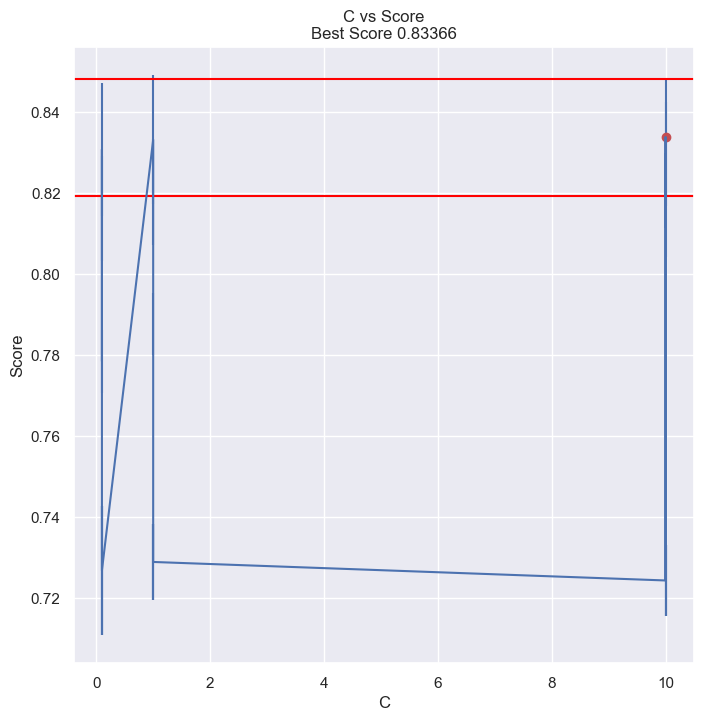

Best Cost parameter : 10
Best gamma parameter : 0.75


In [328]:
# Report best C and gamma
GridSearch_table_plot(grid_svc_acc, "C", negative=False, display_all_params=False)
print('Best Cost parameter : '+ str(grid_svc_acc.best_estimator_.C))
print('Best gamma parameter : '+ str(grid_svc_acc.best_estimator_.gamma))

In [329]:
grid_svc_acc.best_estimator_

SVC(C=10, gamma=0.75)

In [330]:
insample_y_pred_acc = grid_svc_acc.predict(X_res)

# Compute different Evaluation metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix

print('Accuracy Score : ' + str(accuracy_score(y_res,insample_y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_res,insample_y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_res,insample_y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_res,insample_y_pred_acc)))

Accuracy Score : 0.9344161274703993
Precision Score : 0.9156454830436022
Recall Score : 0.729067392784207
F1 Score : 0.8117736230419403


Confusion matrix


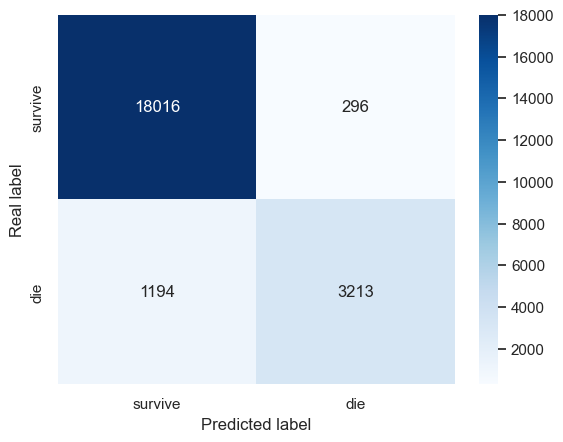

y actual : 
HOSPITAL_EXPIRE_FLAG
0    18312
1     4407
Name: count, dtype: int64
y predicted : 
0    19210
1     3509
Name: count, dtype: int64


In [331]:
#Confusion matrix
print("Confusion matrix")
cm=confusion_matrix(y_res,insample_y_pred_acc)
plot_confusion_matrix(cm, ['survive','die'])
#Distribution of y test
print('y actual : \n' +  str(y_res.value_counts()))
#Distribution of y predicted
print('y predicted : \n' + str(pd.Series(insample_y_pred_acc).value_counts()))

## Final Model

In [1]:
# Create a Support Vector Machine classifier with a linear kernel
#classifier = SVC(kernel='rbf', probability=True,C = 1, gamma='scale',class_weight='balanced')
classifierF = SVC(class_weight='balanced',kernel='linear', probability=True, C=100, gamma=0.75)

# Train the classifier on the training set
classifierF.fit(X_res, y_res)

# Obtain decision values or probabilities on the training set
#y_train_scores = classifier.decision_function(X_train_scaled)  # Use decision_function for linear kernel
# Alternatively, you can use predict_proba for non-linear kernels
y_train_probs_svc = classifierF.predict_proba(Xtest)[:, 1]

NameError: name 'SVC' is not defined

In [246]:
# Produce .csv for kaggle testing
test_predictions_submit_SVM = pd.DataFrame({"icustay_id": Xtest_id['icustay_id'], "HOSPITAL_EXPIRE_FLAG": y_train_probs_svc[0]})
test_predictions_submit_SVM.to_csv("test_predictions_submit_svm_testing22.csv", index = False)